# Twitter Hate Speech Detection

**Please note:** Because of the subject matter of this project, this notebook contains uncensored offensive language from the dataset.


# Overview

# Business Problem

Human content moderation exploits people by consistently traumatizing and underpaying them. In 2019, an [article](https://www.theverge.com/2019/6/19/18681845/facebook-moderator-interviews-video-trauma-ptsd-cognizant-tampa) on The Verge exposed the extensive list of horrific working conditions that employees faced at Cognizant, which was Facebook’s primary moderation contractor. Unfortunately, every major tech company, including Twitter, uses human moderators to some extent, both domestically and overseas.

Hate speech is defined as abusive or threatening speech that expresses prejudice against a particular group, especially on the basis of race, religion or sexual orientation. Usually, the difference between hate speech and offensive language comes down to subtle context or diction. 

Any company with an online forum where users post content could benefit from automating as much as the moderation process as possible. Ultimately, human content moderation is not only detrimental to workers, but also presents a liability to companies that use them.

# Data & Methods

The dataset for this capstone project was sourced from a study called Automated Hate Speech Detection and the Problem of Offensive Language  conducted by Thomas Davidson and a team at Cornell University in 2017. The GitHub repository can be found [here](https://github.com/t-davidson/hate-speech-and-offensive-language). The dataset is provided as a `.csv` file with 24,802 text posts from Twitter where 6% of the tweets were labeled as hate speech. 

Since content moderation is so subjective, the labels on this dataset were crowdsourced and determined by majority-rules. The “class” column labels each tweet as 0 for hate speech, 1 for offensive language or 2 for neither. In order to create a different project and adapt the data to my specific business context, I will be treating the data as a binary classification problem. 

Therefore, the final model will be **predicting whether a tweet is hate speech or not.** To prepare the data for this, I will be manually replacing existing 1 and 2 values as 0, and replacing 0 as 1 to indicate hate speech.

# Data Understanding

### 1. What are the linguistic differences between hate speech and offensive language?

![img1](./visualizations/label_word_count_y.png)

Linguistically, it's important to note that the difference between hate speech and offensive language often comes down to how it targets marginalized communities, often in threatening ways.

Although these graphs have very similar frequently occurring words, there are a few that stand out. For instance, we can notice from this figure that Hate Speech typically contains the N-word with the hard 'R'. **The use of this slur could indicate malicious intent, which goes beyond possibly using the word as slang.**

Examples like that one demonstrate the nuances of English slang and the fine line between Hate Speech and offensive language. **Because of the similarities of each label’s vocabulary, it could be difficult for machine learning algorithms to differentiate between them and determine what counts as Hate Speech.**

### 2. What are the most popular hashtags of each tweet type?

![img2](./visualizations/censored_top_hashtags.png)

From these word clouds, we can see some more parallels and differences between what is classified as hate speech or not. For instance, #tcot stands for "Top Conservatives On Twitter” and it appears in both groups. However, #teabagger, which refers to those who identify with the Tea Party, that is primarily (but not exclusively) associated with the Repubclican Party, appears in only the “Not Hate Speech” cloud. Both hashtags are used among Alt-Right communities.

Additionally, the #r**skins hashtag appears in only the Not Hate Speech cloud. This was the former name of the Washington NFL team. Knowing the context, we know that hashtag could certainly include text that constitutes as hate speech. WIth this, and other hashtags that appear in the “Not Hate Speech” cloud, we can clearly see the very slight differences between the two labels.

Besides that, others are simply pop culture references, such as #Scandal the TV show or #vote5sos referring to the boy band. It’s interesting that those contain a lot of offensive language, probably from fan reactions and community conflicts. Ultimately, we can recommend that **Twitter should closely monitor those top hashtags for potential posts containing hate speech** or even regular offensive language.


### 3. What is the overall polarity of the tweets?

![img3](./visualizations/compound_polarity_score.png)


The compound polarity score is a metric that calculates the sum of all the [lexicon ratings](https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vader_lexicon.txt) which have been normalized between -1 and +1. With -1 being extreme negative and +1 being extreme positive. **This score encompasses the overall sentiment of this corpus.**

- Hate Speech tweets on average have a compound score of -0.363
- Non Hate Speech tweets on average have a compound score of -0.263

According to this metric, both classes of tweets have pretty negative sentiments because their normalized compound scores are less than -0.05. 

Additionally from this graph, we can see that tweets classified as Hate Speech are especially negative. This further emphasizes how slim the difference between the two labels are. Although both classes contain negative and offensive language, Hate Speech is much more negative on average.


![img3](./visualizations/avg_polarity_by_tweet_type.png)


To reiterate, this graph shows the average polarity scores for each label. We can see that a majority were scored as neutral. However, of those that were scored as negative, it seems like "Not Hate Speech" had more on average.

## Class Imbalance

The main roadblock of this dataset is the extreme class imbalance. We can see that only 5.77% of the data is labeled as hate speech. This could present challenges during the modeling process.

![imbalance](./visualizations/cleaned_class_imbalance.png)

In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')
import pickle

# NLP libraries
import nltk
from sklearn.feature_extraction import text 
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# modeling libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, utils, model_selection, svm
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, roc_curve, auc, classification_report

# Preprocessing Text Data

The original data from `twitter_data.csv` was cleaned using RegEx in the `data_cleaning.ipynb` notebook. 

In [193]:
# loading in clean_df
clean_df = pd.read_pickle('./pickle/clean_df.pkl')

In [194]:
clean_df.head(3)

,total_votes,hate_speech_votes,other_votes,label,tweet,clean_tweets
0,3,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't...,as a woman you shouldnt complain about clea...
1,3,0,3,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad for cuffin dat ho...
2,3,0,3,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg you ever fuck a bitch and she sta to...


## Tokenizing & Removing Stop Words

When working with text data, one of the first steps is to remove stop words from the corpus. Although text would be gramatically incorrect without these stop words, they provide little value to models and typically hinder performace.

We can use NLTK's built-in library of stop words to remove them in a tokenizing function.

Additionally, we tokenize text data so that machine learning algorithms can understand it.

In [195]:
# assigning variables to essential columns
data = clean_df['clean_tweets']
target = clean_df['label']

In [196]:
# setting NLTK stop words as `stop_words`
stop_words = set(stopwords.words('english'))

In [197]:
# function to tokeenize text in each column and remove stop words
def process_tweet(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed 

In [198]:
# applying the above function to our data/features 
processed_data = list(map(process_tweet, data))

In [199]:
# getting count of all unique words in the corpus
total_vocab = set()
for comment in processed_data:
    total_vocab.update(comment)
len(total_vocab)

20277

We can see that the corpus has a vocabulary of 20,277 unique words.

## Top Words in Corpus

In [200]:
# morphing `processed_data` into a readable list
flat_filtered = [item for sublist in processed_data for item in sublist]
# getting frequency distribution
clean_corpus_freqdist = FreqDist(flat_filtered)
# top 20 words in cleaned corpus
clean_corpus_freqdist.most_common(20)

[('bitch', 8227),
 ('bitches', 3083),
 ('like', 2766),
 ('hoes', 2368),
 ('pussy', 2099),
 ('im', 2061),
 ('hoe', 1906),
 ('dont', 1749),
 ('got', 1597),
 ('ass', 1570),
 ('get', 1428),
 ('fuck', 1411),
 ('u', 1280),
 ('shit', 1262),
 ('nigga', 1198),
 ('aint', 1158),
 ('trash', 1142),
 ('lol', 1074),
 ('know', 806),
 ('niggas', 791)]

These top words are mostly offensive terms, and some other slang words that the NLTK stop words removal function didn't pick up.

## Lemmatization

This last method reduces each word into a linguistically valid **lemma**, or root word. It does this through linguistic mappings, using the WordNet lexical database.


In [201]:
# creating a list with all lemmatized outputs
lemmatizer = WordNetLemmatizer() 
lemmatized_output = []

for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [202]:
X_lem = lemmatized_output
y_lem = target

Now `X_lem` and `y_lem` are contain cleaned text and the original labels, ready to be used for modeling.

# Feature Engineering

## Train-Test Split

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.20, random_state=15)

## TF-IDF Vectorization

Before tokenized text data can be fed into machine learning models, they must be transformed into numerical feature vectors. First, we’ll be trying one of the most popular methods, TF-IDF Vectorization.

This is an acronym than stands for “Term Frequency — Inverse Document” Frequency which are the components of the resulting scores assigned to each word.
- Term Frequency: This summarizes how often a given word appears within a document.
- Inverse Document Frequency: This down scales words that appear a lot across documents.

Without going into the math, TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across other documents.

In [204]:
# using tf_idf vectorizor
tfidf = TfidfVectorizer(stop_words= stop_words, ngram_range=(1,2))

In [205]:
# sparse matrix format with 265K stored elements
tfidf_data_train = tfidf.fit_transform(X_train)
tfidf_data_test = tfidf.transform(X_test)

In [206]:
# taking a quick look of the non zero elements
non_zero_cols = tfidf_data_train.nnz / float(tfidf_data_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 13.364420457984465
Percentage of columns containing ZERO: 0.9998720483637183


99.9% of the columns contain a zero, meaning that's a very **sparse matrix** with 265K columns

# Modeling Process

## Evaluation Metrics

For this business problem, we will use F1 score as the main metric, while also looking at Precision and Recall. The F1 score finds the harmonic mean between Precision and Recall, and it's useful for data with high class imbalance.

We will also be looking at the weighted F1 score. It can account for the class imbalance in labels by calculating metrics for each label, and finding their average weighted by support (the number of true instances for each label). This results in a F1 score that is not between precision and recall.

Overall, we want as much hate speech to flagged as possible and so that it can be efficiently removed.

## Baseline Modeling

In [247]:
# function to print evaluation metrics
def evaluation(precision, recall, f1, f1_weighted):
    """prints out evaluation metrics for a model"""
    print('Testing Evaluation Metrics:')
    print('Precision: {:.4}'.format(precision))
    print('Recall: {:.4}'.format(recall))
    print('F1 Score: {:.4}'.format(f1))
    print('Weighted F1 Score: {:.4}'.format(f1_weighted))

## Baseline Random Forest

A random forest model is an ensamble method that uses multiple Decision Trees to try to predict the output variable. Typically, it's one of the best performing models for classification problems.

In [208]:
rf_baseline = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=0)
# adding class_weight='balanced' increased accuracy & precision but decreased F1

⏳ the cell below takes about 38 seconds to run

In [209]:
%%time
rf_baseline.fit(tfidf_data_train, y_train)
rf_test_preds = rf_baseline.predict(tfidf_data_test)

CPU times: user 37.1 s, sys: 142 ms, total: 37.3 s
Wall time: 37.4 s


In [210]:
rf_precision = precision_score(y_test, rf_test_preds)
rf_recall = recall_score(y_test, rf_test_preds)
rf_f1_score = f1_score(y_test, rf_test_preds)
rf_f1_weighted = f1_score(y_test, rf_test_preds, average='weighted')

In [211]:
evaluation(rf_precision, rf_recall, rf_f1_score, rf_f1_weighted)

Testing Evaluation Metrics:
Precision: 0.4128
Recall: 0.1613
F1 Score: 0.232
Weighted F1 Score: 0.9272


These scores are not ideal becuase the F1 is being brought down on how the model predicts the "Hate Speech" label. The weighted F1 score mostly shows how the model is predicting the majority class, "Not Hate Speech". From here, we should try models with class imbalance methods to try and get the unweighted F1 to improve.

In [212]:
# creating dictionary to store all metrics
metric_dict = {}
# adding scores to metric_dict
metric_dict['Baseline Random Forest'] = {'precision': rf_precision, 'recall': rf_recall, 'f1_score': rf_f1_score, 'weighted_f1': rf_f1_weighted}

## Baseline Logistic Regression

Logistic Regression is another common model used for clasification tasks.

In [213]:
logreg_baseline = LogisticRegression(penalty='l2', class_weight='balanced', random_state=20)
# class_weight='balanced' actually didn't impact the score

⏳ the cell below takes about 3 seconds to run

In [214]:
%%time
logreg_baseline.fit(tfidf_data_train, y_train)
logreg_test_preds = logreg_baseline.predict(tfidf_data_test)

CPU times: user 3.15 s, sys: 229 ms, total: 3.38 s
Wall time: 1.19 s


In [215]:
logreg_precision = precision_score(y_test, logreg_test_preds)
logreg_recall = recall_score(y_test, logreg_test_preds)
logreg_f1_score = f1_score(y_test, logreg_test_preds)
logreg_f1_weighted = f1_score(y_test, logreg_test_preds, average='weighted')

In [216]:
evaluation(logreg_precision, logreg_recall, logreg_f1_score, logreg_f1_weighted)

Testing Evaluation Metrics:
Precision: 0.2939
Recall: 0.5699
F1 Score: 0.3878
Weighted F1 Score: 0.9134


In [217]:
# adding scores to metric_dict
metric_dict['Baseline Logisitic Regression'] = {'precision': logreg_precision, 'recall': logreg_recall, 'f1_score': logreg_f1_score, 'weighted_f1': logreg_f1_weighted}

## Baseline Naive Bayes

In [218]:
baseline_bayes = MultinomialNB(alpha = .01)

⏳ the cell below takes about 11 seconds to run

In [219]:
%%time
baseline_bayes.fit(tfidf_data_train, y_train)
bayes_test_preds = baseline_bayes.predict(tfidf_data_test)

CPU times: user 10.6 ms, sys: 5.97 ms, total: 16.6 ms
Wall time: 15.8 ms


In [220]:
bayes_precision = precision_score(y_test, bayes_test_preds)
bayes_recall = recall_score(y_test, bayes_test_preds)
bayes_f1_score = f1_score(y_test, bayes_test_preds)
bayes_f1_weighted = f1_score(y_test, bayes_test_preds, average='weighted')

In [221]:
evaluation(bayes_precision, bayes_recall, bayes_f1_score, bayes_f1_weighted)

Testing Evaluation Metrics:
Precision: 0.4118
Recall: 0.1254
F1 Score: 0.1923
Weighted F1 Score: 0.9255


In [222]:
# adding scores to metric_dict
metric_dict['Baseline Naive Bayes'] = {'precision': bayes_precision, 'recall': bayes_recall, 'f1_score': bayes_f1_score, 'weighted_f1': bayes_f1_weighted}

## Baseline Support Vector Machine (SVM)

In [223]:
SVM_baseline = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight='balanced')

⏳ the cell below takes about 1 minute to run

In [224]:
%%time 
# fit the training dataset on the classifier
SVM_baseline.fit(tfidf_data_train, y_train)
# predict the labels on validation dataset
SVM_test_preds = SVM_baseline.predict(tfidf_data_test)

CPU times: user 48.6 s, sys: 663 ms, total: 49.2 s
Wall time: 49.4 s


In [225]:
SVM_precision = precision_score(y_test, SVM_test_preds)
SVM_recall = recall_score(y_test, SVM_test_preds)
SVM_f1_score = f1_score(y_test, SVM_test_preds)
SVM_f1_weighted = f1_score(y_test, SVM_test_preds, average='weighted')

In [226]:
evaluation(SVM_precision, SVM_recall, SVM_f1_score, SVM_f1_weighted)

Testing Evaluation Metrics:
Precision: 0.3609
Recall: 0.4373
F1 Score: 0.3955
Weighted F1 Score: 0.9281


In [227]:
# adding scores to metric_dict
metric_dict['Baseline SVM'] = {'precision': SVM_precision, 'recall': SVM_recall, 'f1_score': SVM_f1_score, 'weighted_f1': SVM_f1_weighted}

## Evaluation Metrics for All Baseline Models

In [228]:
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,f1_score,weighted_f1
Baseline Random Forest,0.412844,0.161290,0.231959,0.927249
Baseline Logisitic Regression,0.293900,0.569892,0.387805,0.913449
Baseline Naive Bayes,0.411765,0.125448,0.192308,0.925487
Baseline SVM,0.360947,0.437276,0.395462,0.928112


Overall, the SVM model performed the best across unweighted and weighted F1. However, there is still work to be done to bring that score up higher. Next we'll try improving that model with grid search.

# Doc2Vec

One disadvantage to using Count Vectorization or TF-DF Vectorization is that we can run into the Curse of Dimensionality. This is because these methods create Sparse Vectors, that are the length of the total vocabulary of the text corpus. Therefore, this extra space of 99% 0s could possibly hurt the model. 

We can try Doc2Vec, which is an extension of Word2Vec. It aims to learn how to project a document into a latent d-dimensional space. Specifically, the Distributed Bag of Words (DBOW) model ignores the context words in the input, but instead forces the model to predict words randomly sampled from the paragraph in the output.

In [229]:
# fresh TTS for doc2vec data
doc_train, doc_test = train_test_split(clean_df, test_size=0.3, random_state=42)

## Data Preparation

In [230]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [231]:
tagged_train = doc_train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['clean_tweets']), tags=[r.label]), axis=1)
tagged_test = doc_test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['clean_tweets']), tags=[r.label]), axis=1)

In [232]:
tagged_train.values[30]

TaggedDocument(words=['this', 'bitch', 'instating', 'and', 'driving', 'for', 'me'], tags=[0])

## Training DBOW Model


In [233]:
# train a doc2vec model, using only training data
dbow_model = Doc2Vec(vector_size=100, 
                alpha=0.025, 
                min_count=5,
                dm=1, epochs=100)

In [234]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

# building vocabulary 
dbow_model.build_vocab([x for x in tqdm(tagged_train.values)])


100%|██████████| 17348/17348 [00:00<00:00, 2979273.05it/s]


⏳ the cell below takes about 26 seconds to run

In [235]:
%%time
for epoch in range(30):
    dbow_model.train(utils.shuffle([x for x in tqdm(tagged_train.values)]), total_examples=len(tagged_train.values), epochs=1)
    dbow_model.alpha -= 0.002
    dbow_model.min_alpha = dbow_model.alpha

100%|██████████| 17348/17348 [00:00<00:00, 2692923.23it/s]
CPU times: user 27.7 s, sys: 4.39 s, total: 32.1 s
Wall time: 24.4 s


### Final Vector Feature for Classification Model Use

In [236]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

## Applying Doc2Vec Data to SVM Baseline

In [237]:
# train-test split
doc_y_train, doc_X_train = vec_for_learning(dbow_model, tagged_train)
doc_y_test, doc_X_test = vec_for_learning(dbow_model, tagged_test)

In [238]:
Doc2Vec_SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight='balanced')

⏳ the cell below takes about 28 seconds to run

In [239]:
%%time
# fit the training dataset on the classifier
Doc2Vec_SVM.fit(doc_X_train, doc_y_train)

CPU times: user 27.8 s, sys: 282 ms, total: 28.1 s
Wall time: 28.1 s


SVC(class_weight='balanced', gamma='auto', kernel='linear')

In [240]:
# predict the labels on validation dataset
doc_SVM_y_preds = Doc2Vec_SVM.predict(doc_X_test)

In [241]:
doc_SVM_precision = precision_score(doc_y_test, doc_SVM_y_preds)
doc_SVM_recall = recall_score(doc_y_test, doc_SVM_y_preds)
doc_SVM_f1_score = f1_score(doc_y_test, doc_SVM_y_preds)
doc_SVM_f1_weighted = f1_score(doc_y_test, doc_SVM_y_preds, average='weighted')

In [242]:
evaluation(doc_SVM_precision, doc_SVM_recall, doc_SVM_f1_score, doc_SVM_f1_weighted)

Testing Evaluation Metrics:
Precision: 0.1879
Recall: 0.6253
F1 Score: 0.289
Weighted F1 Score: 0.8641


In [243]:
metric_dict['Baseline SVM with Doc2Vec'] = {'precision': doc_SVM_precision, 'recall': doc_SVM_recall, 'f1_score': doc_SVM_f1_score, 'weighted_f1': doc_SVM_f1_weighted}

## Comparing with Other Models

In [244]:
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,f1_score,weighted_f1
Baseline Random Forest,0.412844,0.161290,0.231959,0.927249
Baseline Logisitic Regression,0.293900,0.569892,0.387805,0.913449
Baseline Naive Bayes,0.411765,0.125448,0.192308,0.925487
Baseline SVM,0.360947,0.437276,0.395462,0.928112
Baseline SVM with Doc2Vec,0.187896,0.625293,0.288961,0.864053


Looks like the Doc2Vec model didn't perform as well. Let's look at this closer with a classification report, so see how both models predicted each label.

## SVM Baselines: TF-IDF vs. Doc2Vec

In [245]:
target_names = ['class 0', 'class 1']
# Tf-IDF baseline
print('-'*14 + ' SVM Baseline with TF-IDF ' + '-'*13)
print(classification_report(y_test, SVM_test_preds, target_names=target_names))
# Doc2Vec baseline
print('-'*13 + ' SVM Baseline with Doc2Vec ' + '-'*13)
print(classification_report(doc_y_test, doc_SVM_y_preds, target_names=target_names))

-------------- SVM Baseline with TF-IDF -------------
              precision    recall  f1-score   support

     class 0       0.97      0.95      0.96      4678
     class 1       0.36      0.44      0.40       279

    accuracy                           0.92      4957
   macro avg       0.66      0.70      0.68      4957
weighted avg       0.93      0.92      0.93      4957

------------- SVM Baseline with Doc2Vec -------------
              precision    recall  f1-score   support

     class 0       0.97      0.84      0.90      7008
     class 1       0.19      0.63      0.29       427

    accuracy                           0.82      7435
   macro avg       0.58      0.73      0.59      7435
weighted avg       0.93      0.82      0.86      7435



The Doc2Vec method actually performed worse than the TF-IDF method. We can see that it didnt predict the 1 or 0 label as well as the TF-IDF Vectorized model.

Let's go back to the original SVM Baseline and try other class imbalance remedy methods to improve the scores

# Dealing with Class Imbalance

The initial SVM Baseline dealt with class imbalance with the parameter `class_weight='balanced'`. Let's try other clas imbalance remedy methods.

## Over-Sampling with SMOTE
Over-samples the minority class, hate speech.

In [248]:
sm = SMOTE(random_state=35)
smote_X_train, smote_y_train = sm.fit_sample(tfidf_data_train, y_train)

In [249]:
smote_SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', random_state=15)

⏳ the cell below takes about 4 minutes to run

In [250]:
%%time
smote_SVM.fit(smote_X_train, smote_y_train)
smote_SVM_test_preds = smote_SVM.predict(tfidf_data_test)

CPU times: user 3min 52s, sys: 2.45 s, total: 3min 54s
Wall time: 3min 58s


In [251]:
smote_precision = precision_score(y_test, smote_SVM_test_preds)
smote_recall = recall_score(y_test, smote_SVM_test_preds)
smote_f1_score = f1_score(y_test, smote_SVM_test_preds)
smote_weighted_f1_score = f1_score(y_test, smote_SVM_test_preds, average='weighted')

In [252]:
evaluation(smote_precision, smote_recall, smote_f1_score, smote_weighted_f1_score)

Testing Evaluation Metrics:
Precision: 0.3393
Recall: 0.2724
F1 Score: 0.3022
Weighted F1 Score: 0.9255


In [253]:
# adding these metrics to evaluation metric dict
metric_dict['SVM Oversampled with SMOTE'] = {'precision': smote_precision, 'recall': smote_recall, 'f1_score': smote_f1_score, 'weighted_f1': smote_weighted_f1_score}

## Under-Sampling with TomeK Links
Under-samples the majoirty class, not hate speech.

In [254]:
tl = TomekLinks()
tomek_X_train, tomek_y_train = tl.fit_resample(tfidf_data_train, y_train)
print('Resampled dataset shape %s' % Counter(tomek_y_train))

Resampled dataset shape Counter({0: 18627, 1: 1151})


It only removed 48 values from the majority class.

In [255]:
tomek_SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', random_state=15)

⏳ the cell below takes about 43 seconds to run

In [256]:
%%time
tomek_SVM.fit(tomek_X_train, tomek_y_train)
tomek_logreg_test_preds = tomek_SVM.predict(tfidf_data_test)

CPU times: user 42.3 s, sys: 782 ms, total: 43.1 s
Wall time: 43.8 s


In [257]:
tomek_precision = precision_score(y_test, tomek_logreg_test_preds)
tomek_recall = recall_score(y_test, tomek_logreg_test_preds)
tomek_f1_score = f1_score(y_test, tomek_logreg_test_preds)
tomek_weighted_f1_score = f1_score(y_test, tomek_logreg_test_preds, average='weighted')

In [258]:
evaluation(tomek_precision, tomek_recall, tomek_f1_score, tomek_weighted_f1_score)

Testing Evaluation Metrics:
Precision: 0.6562
Recall: 0.2258
F1 Score: 0.336
Weighted F1 Score: 0.938


In [259]:
# adding these metrics to evaluation metric dict
metric_dict['SVM Undersampled with Tomek Links'] = {'precision': tomek_precision, 'recall': tomek_recall, 'f1_score': tomek_f1_score, 'weighted_f1': tomek_weighted_f1_score}

## Comparing with Other Models

In [260]:
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,f1_score,weighted_f1
Baseline Random Forest,0.412844,0.161290,0.231959,0.927249
Baseline Logisitic Regression,0.293900,0.569892,0.387805,0.913449
Baseline Naive Bayes,0.411765,0.125448,0.192308,0.925487
Baseline SVM,0.360947,0.437276,0.395462,0.928112
Baseline SVM with Doc2Vec,0.187896,0.625293,0.288961,0.864053
SVM Oversampled with SMOTE,0.339286,0.272401,0.302187,0.925527
SVM Undersampled with Tomek Links,0.656250,0.225806,0.336000,0.937993


- The baseline SVM with `class_weight=balanced` has the highest unweighted F1
- The undersampled baseline has a lower raw F1, but higher weighted F1.

We can take a look at each model's classification report to get a better idea about what's happening.

In [266]:
target_names = ['class 0', 'class 1']
# class_weight='balanced' Baseline report
print('-'*9 + ' SVM with `class_weight=balanced` ' + '-'*10)
print(classification_report(y_test, SVM_test_preds, target_names=target_names))
print('-'*9 + ' SVM Undersampled with Tomek Links ' + '-'*9)
# Undersampled Baseline report
print(classification_report(y_test, tomek_logreg_test_preds, target_names=target_names))

--------- SVM with `class_weight=balanced` ----------
              precision    recall  f1-score   support

     class 0       0.97      0.95      0.96      4678
     class 1       0.36      0.44      0.40       279

    accuracy                           0.92      4957
   macro avg       0.66      0.70      0.68      4957
weighted avg       0.93      0.92      0.93      4957

--------- SVM Undersampled with Tomek Links ---------
              precision    recall  f1-score   support

     class 0       0.96      0.99      0.97      4678
     class 1       0.66      0.23      0.34       279

    accuracy                           0.95      4957
   macro avg       0.81      0.61      0.65      4957
weighted avg       0.94      0.95      0.94      4957



There are some differances. But most noteably, the baseline with `class_weight=balanced` predicts the hate speech (1) class much better than the other model. 

Therefore, let's stick with that one and grid search to tune its hyperparameters.

# Grid Search

In [267]:
# creating the model
grid_model = svm.SVC(degree=3, class_weight='balanced', random_state=20)

In [268]:
# creating param_dict
param_dict={'C': [1, 10, 100],  
              'gamma': [0.1, 0.01, 0.001], 
              'kernel': ['rbf', 'sigmoid']}

In [269]:
# instantiate Grid Search CV with F1 metric
grid_baseline = GridSearchCV(grid_model, param_dict, cv=5, scoring='f1', verbose=3)

⏳ the cell below takes about **49 minutes** to run

In [270]:
%%time
# fit the grid search to our data
grid_baseline.fit(tfidf_data_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.433, total=  24.6s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.6s remaining:    0.0s
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.465, total=  25.8s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   50.4s remaining:    0.0s
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.446, total=  25.6s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.456, total=  25.3s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.405, to

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', random_state=20),
             param_grid={'C': [1, 10, 100], 'gamma': [0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'sigmoid']},
             scoring='f1', verbose=3)

In [271]:
# generate score with .best_score_ and hyperparemeters with .best_params_
print('F1 Score:', grid_baseline.best_score_)
print('Best Hyperparameters:', grid_baseline.best_params_)
print('Model object with best parameters: ')
print(grid_baseline.best_estimator_)

F1 Score: 0.44115028504856885
Best Hyperparameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Model object with best parameters: 
SVC(C=1, class_weight='balanced', gamma=0.1, random_state=20)


The grid search found that the best hyperparameters are `{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}`.


In [272]:
# Predict the response for test dataset
grid_base_y_pred_train = grid_baseline.best_estimator_.predict(tfidf_data_train)

# predict the training set
grid_base_y_pred_test = grid_baseline.best_estimator_.predict(tfidf_data_test)

In [273]:
# setting variables for evaluation metrics
grid_precision = precision_score(y_test, grid_base_y_pred_test)
grid_recall = recall_score(y_test, grid_base_y_pred_test)
grid_f1_score = f1_score(y_test, grid_base_y_pred_test)
grid_weighted_f1_score = f1_score(y_test, grid_base_y_pred_test, average='weighted')

In [277]:
evaluation(grid_precision, grid_recall, grid_f1_score, grid_weighted_f1_score)

Testing Evaluation Metrics:
Precision: 0.2808
Recall: 0.6129
F1 Score: 0.3851
Weighted F1 Score: 0.9083


In [278]:
# adding these metrics to evaluation metric dict
metric_dict['Grid Search SVM'] = {'precision': grid_precision, 'recall': grid_recall, 'f1_score': grid_f1_score, 'weighted_f1': grid_weighted_f1_score}

# Evaluating All Models

In [279]:
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,f1_score,weighted_f1
Baseline Random Forest,0.412844,0.161290,0.231959,0.927249
Baseline Logisitic Regression,0.293900,0.569892,0.387805,0.913449
Baseline Naive Bayes,0.411765,0.125448,0.192308,0.925487
Baseline SVM,0.360947,0.437276,0.395462,0.928112
Baseline SVM with Doc2Vec,0.187896,0.625293,0.288961,0.864053
SVM Oversampled with SMOTE,0.339286,0.272401,0.302187,0.925527
SVM Undersampled with Tomek Links,0.656250,0.225806,0.336000,0.937993
Grid Search SVM,0.280788,0.612903,0.385135,0.908306


Unfortunately, the model with grid searched hyperparameters didn't perform better than the baseline. Therefore, the final model will be the baseline Linear SVM model.

# Final Model Analysis: Linear SVM

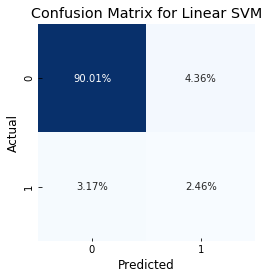

In [330]:
# generating confusion matrix
mat = confusion_matrix(y_test, SVM_test_preds)
sns.heatmap(mat / np.sum(mat) , square=True, annot=True, fmt='.2%', cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Linear SVM')

# fixing matplotlib heatmap cutoff issue
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.savefig('./visualizations/linear_svm_confusion_matrix.png', bbox_inches = "tight", pad_inches=.5)

In [ ]:
# is the model overfit or underfit??

# Conclusion

![venn](./visualizations/word_venn.png)

# Next Steps